 <img src="https://cdn2.iconfinder.com/data/icons/real-estate-60/300/12-512.png" align="left" width="58">
 

# Predicting Housing Prices

This notebook is what I used for my submission in the kaggle [housing prices competiton](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

My submission is in the top 25% of the leaderboard... however many of the top scores above mine are a product of cheating/memorization as they have a RMSE of almost a true 0.

In this notebook I use the following techniques:
* EDA
* Feature Engineering
* Cleaning and Imputing
* Outliers
* Model Optimization


In [1]:
from math import sqrt

import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper, CategoricalImputer, FunctionTransformer

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

## EDA

In [3]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
df.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
T

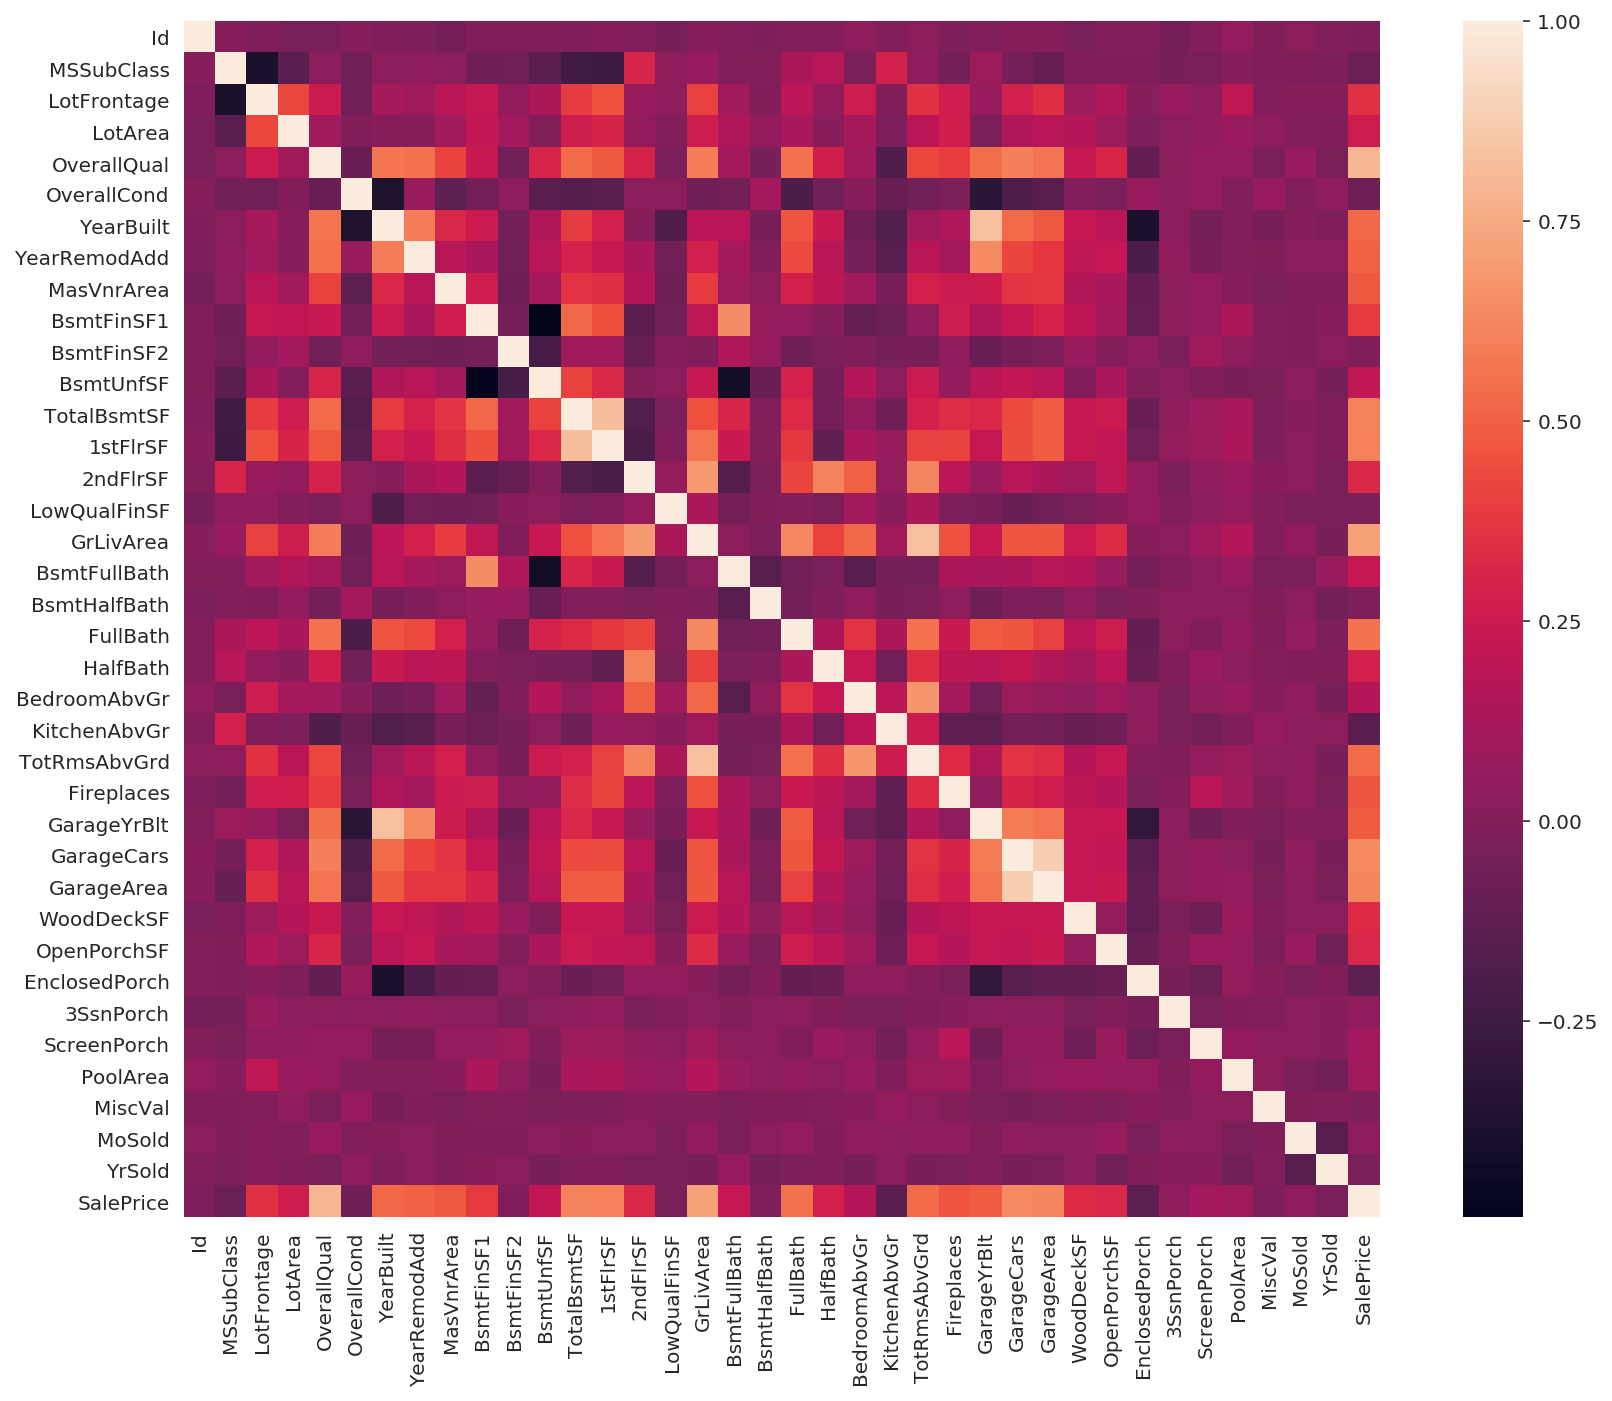

In [6]:
f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(df.corr(), square=True);

The heatmap allows for correlations to be visually detected through the colour gradient. No real suprises appear here as the most correlated values are "total basement sqft and first floor sqft" as well as "garage cars and garage area"

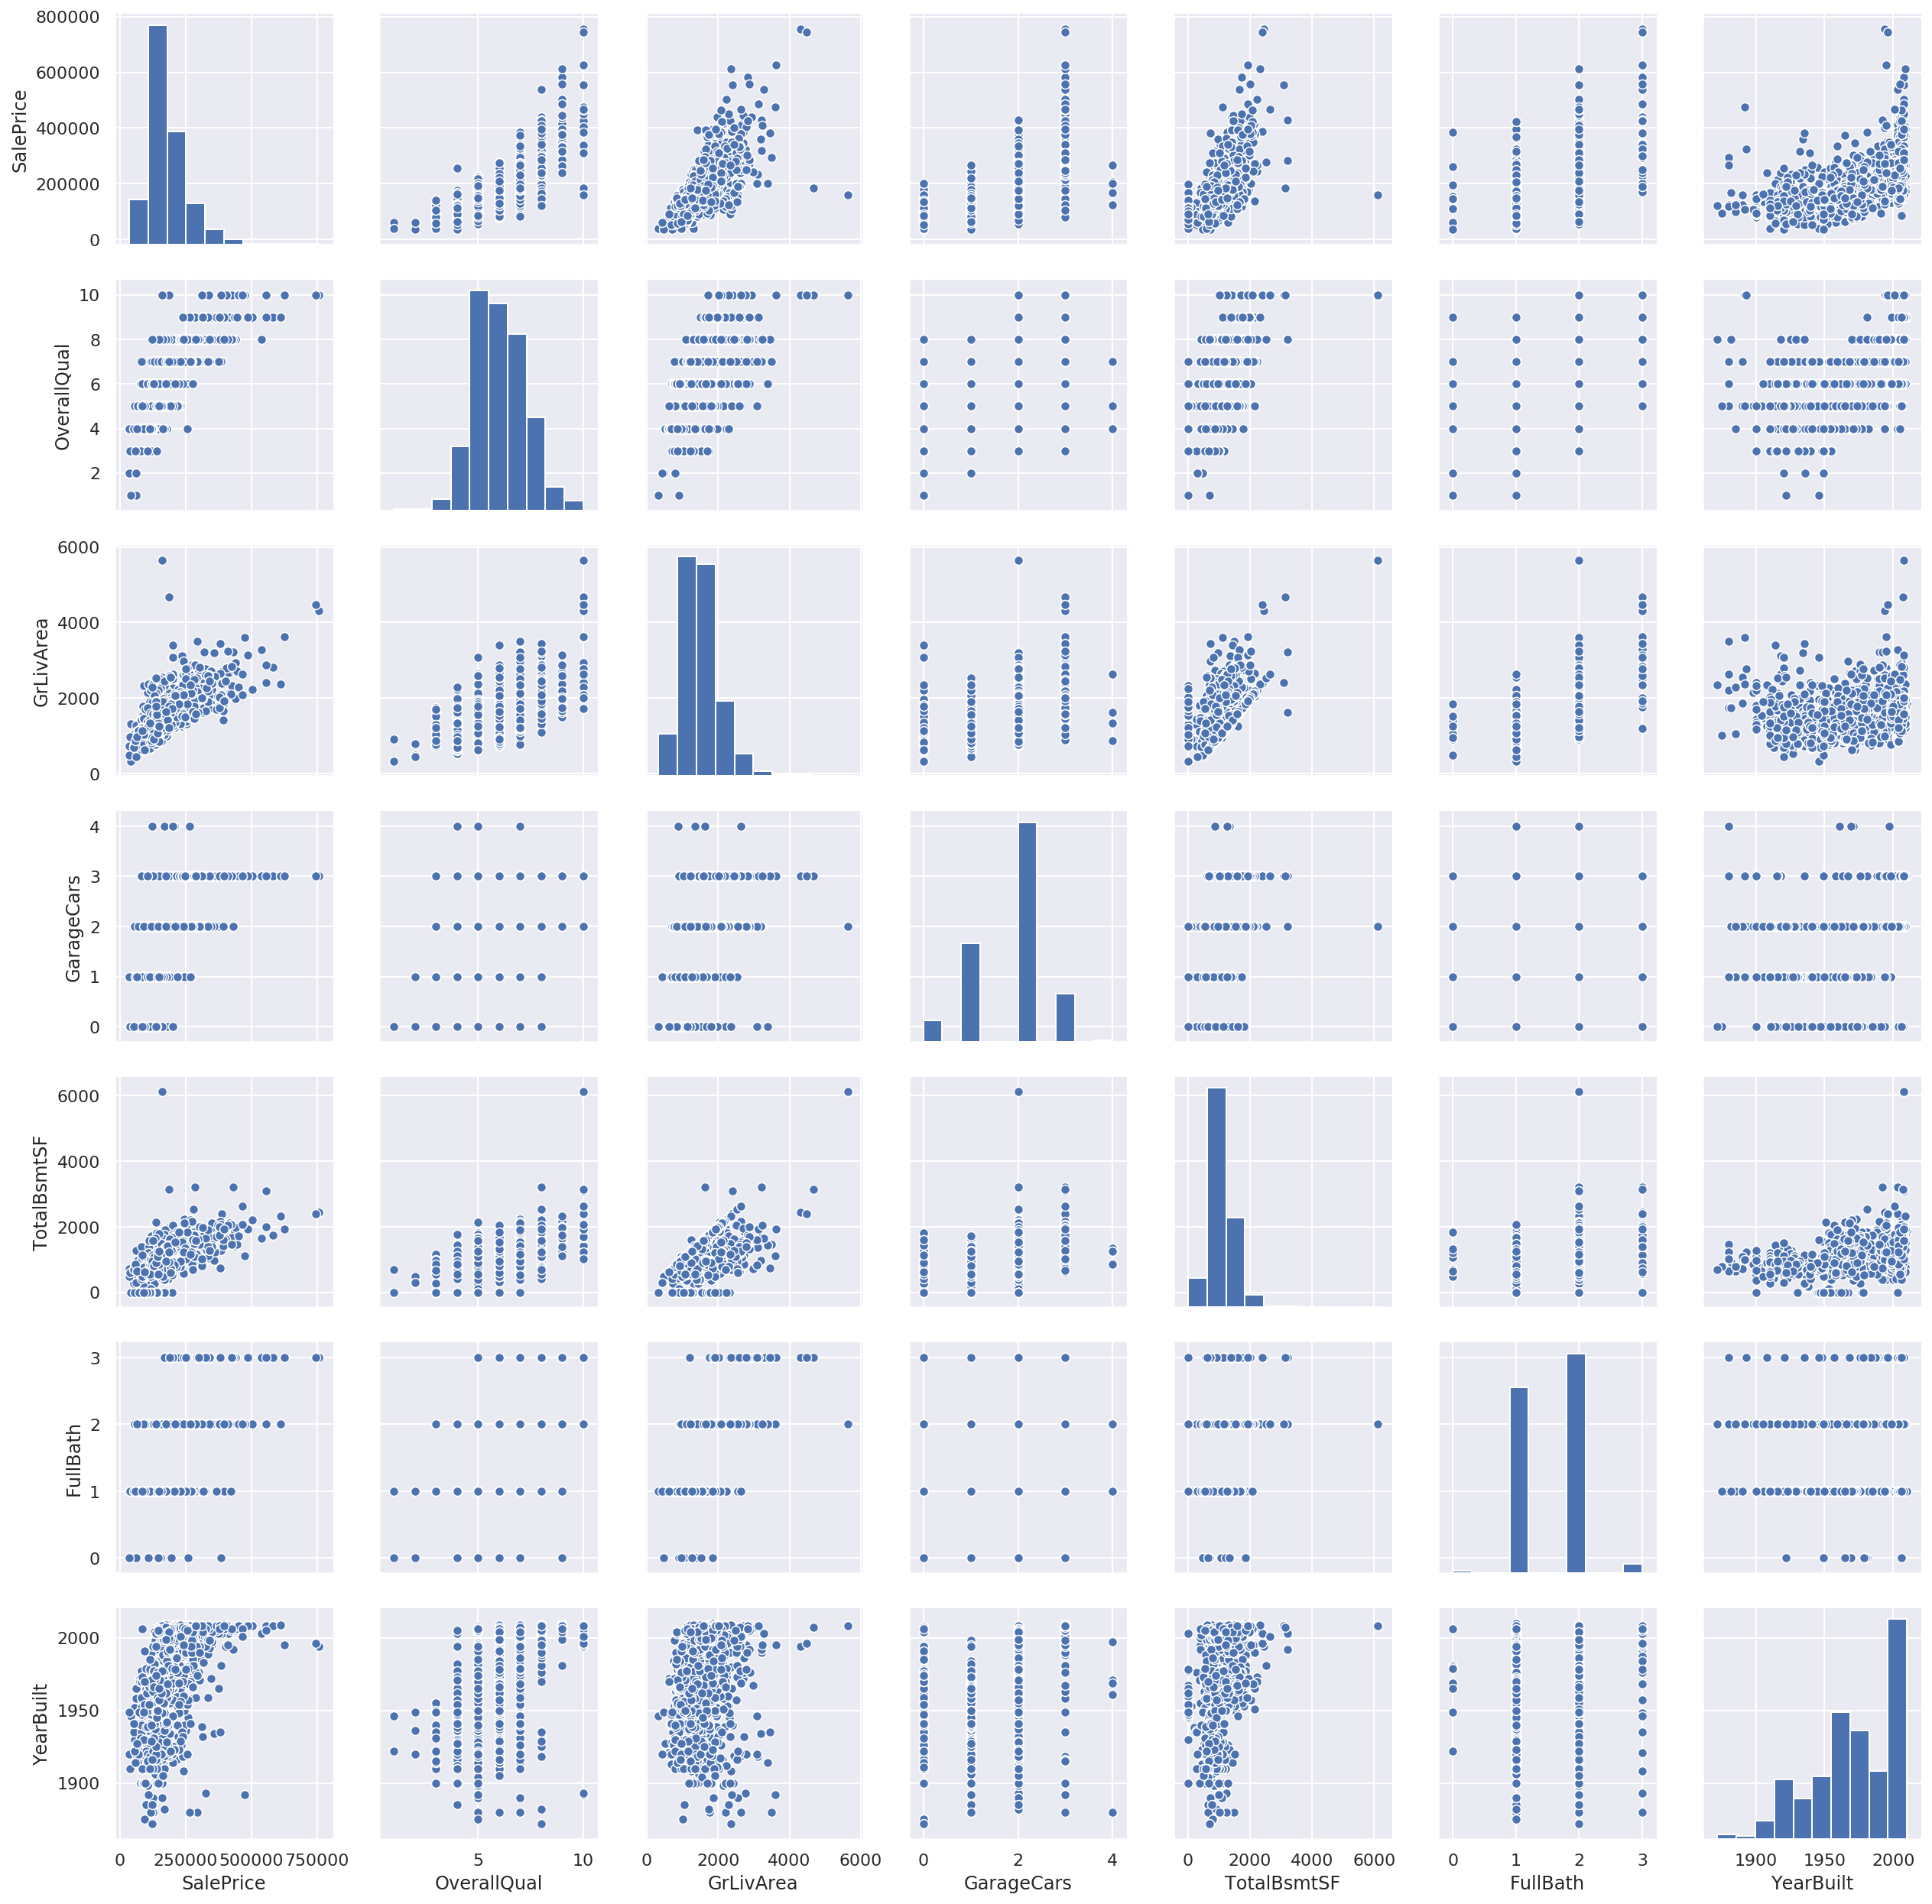

In [7]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], height = 2.5)
plt.show();

This set of plots shows the relationship between what I think are the most important features to a house. Most plots exhibit the expected trends.

In [8]:
df.isna().sum()[:40]

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
Alley           1369
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
dtype: int64

In [9]:
df.isna().sum()[40:]

HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           1453
Fence            1179
MiscFeature      1406
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
dtype: int64

## Removing Visible Outliers

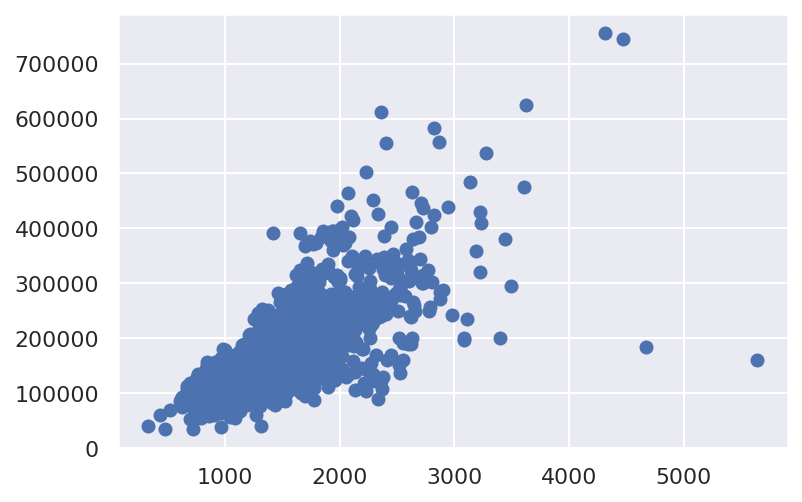

In [10]:
plt.scatter(df['GrLivArea'], df['SalePrice'])

In [11]:
df[(df['GrLivArea'] > 4000) & (df['SalePrice'] <200_000)]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523    524          60       RL        130.0    40094   Pave   NaN      IR1   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
523          Bnk    AllPub  ...        0    NaN   NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
523      10   2007       New        Partial     184750  
1298      1   2008       New        Partial     160000  

[2 rows x 81 columns]

In [12]:
df = df.drop([523,1298])

## Feature Engineering

Imputing LotFrontage based on the Neighborhood

In [13]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [14]:
df['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [15]:
df[df['GarageQual'].isnull()][['GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars','GarageArea', 'GarageQual', 'GarageCond']]

GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
39          NaN          NaN          NaN           0           0        NaN   
48          NaN          NaN          NaN           0           0        NaN   
78          NaN          NaN          NaN           0           0        NaN   
88          NaN          NaN          NaN           0           0        NaN   
89          NaN          NaN          NaN           0           0        NaN   
...         ...          ...          ...         ...         ...        ...   
1349        NaN          NaN          NaN           0           0        NaN   
1407        NaN          NaN          NaN           0           0        NaN   
1449        NaN          NaN          NaN           0           0        NaN   
1450        NaN          NaN          NaN           0           0        NaN   
1453        NaN          NaN          NaN           0           0        NaN   

     GarageCond  
39          NaN  
48          NaN  
78          NaN  
88          NaN  
89          NaN  
...         ...  
1349        NaN  
1407        NaN  
1449        NaN  
1450        NaN  
1453        NaN  

[81 rows x 7 columns]

It seems that all the NaN values have GarageCars & GarageArea as zero so I am going to assume NaN as None

In [16]:
target = 'SalePrice'
y = np.log(df[target])
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Applying Imputers, Scalers, and Dummies/Binnerizers based on the column

In [17]:
mapper = DataFrameMapper([
    (['MSSubClass'], [SimpleImputer(), StandardScaler()]),
    (['MSZoning'], [CategoricalImputer(), LabelBinarizer()]),
    (['LotFrontage'], [SimpleImputer(fill_value=0), StandardScaler()]),
    (['LotArea'], [SimpleImputer(), StandardScaler()]),
    (['Street'], [CategoricalImputer(), LabelBinarizer()]),
    (['Alley'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['LotShape'], [CategoricalImputer(), LabelBinarizer()]),
    (['LandContour'], [CategoricalImputer(), LabelBinarizer()]),
    (['Utilities'], [CategoricalImputer(), LabelBinarizer()]),
    (['LotConfig'], [CategoricalImputer(), LabelBinarizer()]),
    (['LandSlope'], [CategoricalImputer(), LabelBinarizer()]),
    (['Neighborhood'], [CategoricalImputer(), LabelBinarizer()]),
    (['Condition1'], [CategoricalImputer(), LabelBinarizer()]),
    (['Condition2'], [CategoricalImputer(), LabelBinarizer()]),
    (['BldgType'], [CategoricalImputer(), LabelBinarizer()]),
    (['HouseStyle'], [CategoricalImputer(), LabelBinarizer()]),
    (['OverallQual'], [SimpleImputer(), StandardScaler()]),
    (['OverallCond'], [SimpleImputer(), StandardScaler()]),
    (['YearBuilt'], [SimpleImputer(), StandardScaler()]),
    (['YearRemodAdd'], [SimpleImputer(), StandardScaler()]),
    (['RoofStyle'], [CategoricalImputer(), LabelBinarizer()]),
    (['RoofMatl'], [CategoricalImputer(), LabelBinarizer()]),
    (['Exterior1st'], [CategoricalImputer(), LabelBinarizer()]),
    (['Exterior2nd'], [CategoricalImputer(), LabelBinarizer()]),
    (['MasVnrType'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['MasVnrArea'], [SimpleImputer(fill_value=0), StandardScaler()]),
    (['ExterQual'], [CategoricalImputer(), LabelBinarizer()]),
    (['ExterCond'], [CategoricalImputer(), LabelBinarizer()]),
    (['Foundation'], [CategoricalImputer(), LabelBinarizer()]),
    (['BsmtQual'], [CategoricalImputer(), LabelBinarizer()]),
    (['BsmtCond'], [CategoricalImputer(), LabelBinarizer()]),
    (['BsmtExposure'], [CategoricalImputer(), LabelBinarizer()]),
    (['BsmtFinType1'], [CategoricalImputer(), LabelBinarizer()]),
    (['BsmtFinSF1'], [SimpleImputer(), StandardScaler()]),
    (['BsmtFinType2'], [CategoricalImputer(), LabelBinarizer()]),
    (['BsmtFinSF2'], [SimpleImputer(), StandardScaler()]),
    (['BsmtUnfSF'], [SimpleImputer(), StandardScaler()]),
    (['TotalBsmtSF'], [SimpleImputer(), StandardScaler()]),
    (['Heating'], [CategoricalImputer(), LabelBinarizer()]),
    (['HeatingQC'], [CategoricalImputer(), LabelBinarizer()]),
    (['CentralAir'], [CategoricalImputer(), LabelBinarizer()]),
    (['Electrical'], [CategoricalImputer(strategy='constant',fill_value='SBrkr'), LabelBinarizer()]),
    (['1stFlrSF'], [SimpleImputer(), StandardScaler()]),
    (['2ndFlrSF'], [SimpleImputer(), StandardScaler()]),
    (['LowQualFinSF'], [SimpleImputer(), StandardScaler()]),
    (['GrLivArea'], [SimpleImputer(), StandardScaler()]),
    (['BsmtFullBath'], [SimpleImputer(), StandardScaler()]),
    (['BsmtHalfBath'], [SimpleImputer(), StandardScaler()]),
    (['FullBath'], [SimpleImputer(), StandardScaler()]),
    (['HalfBath'], [SimpleImputer(), StandardScaler()]),
    (['BedroomAbvGr'], [SimpleImputer(), StandardScaler()]),
    (['KitchenAbvGr'], [SimpleImputer(), StandardScaler()]),
    (['KitchenQual'], [CategoricalImputer(), LabelBinarizer()]),
    (['TotRmsAbvGrd'], [SimpleImputer(), StandardScaler()]),
    (['Functional'], [CategoricalImputer(strategy='constant',fill_value='Typ'), LabelBinarizer()]),
    (['Fireplaces'], [SimpleImputer(), StandardScaler()]),
    (['FireplaceQu'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['GarageType'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['GarageYrBlt'], [SimpleImputer(fill_value=0), StandardScaler()]),
    (['GarageFinish'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['GarageCars'], [SimpleImputer(), StandardScaler()]),
    (['GarageArea'], [SimpleImputer(), StandardScaler()]),
    (['GarageQual'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['GarageCond'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['PavedDrive'], [CategoricalImputer(), LabelBinarizer()]),
    (['WoodDeckSF'], [SimpleImputer(), StandardScaler()]),
    (['OpenPorchSF'], [SimpleImputer(), StandardScaler()]),
    (['EnclosedPorch'], [SimpleImputer(), StandardScaler()]),
    (['3SsnPorch'], [SimpleImputer(), StandardScaler()]),
    (['ScreenPorch'], [SimpleImputer(), StandardScaler()]),
    (['PoolArea'], [SimpleImputer(fill_value=0), StandardScaler()]),
    (['PoolQC'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['Fence'], [CategoricalImputer(fill_value='None'), LabelBinarizer()]),
    (['MiscFeature'], [CategoricalImputer(strategy='constant',fill_value='None'), LabelBinarizer()]),
    (['MiscVal'], [SimpleImputer(), StandardScaler()]),
    (['MoSold'], [SimpleImputer(), StandardScaler()]),
    (['YrSold'], [SimpleImputer(), StandardScaler()]),
    (['SaleType'], [CategoricalImputer(), LabelBinarizer()]),
    (['SaleCondition'], [CategoricalImputer(), LabelBinarizer()]),
 ], df_out=True)

In [18]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

In [19]:
Z_train.head()

MSSubClass  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  \
848    -0.154991                 0            0            0            1   
810    -0.860356                 0            0            0            1   
1384   -0.154991                 0            0            0            1   
1062    3.136711                 0            0            0            0   
953     0.080131                 0            0            0            1   

      MSZoning_RM  LotFrontage   LotArea  Street  Alley_Grvl  ...  \
848             0     0.232250  3.190015       1           0  ...   
810             0     0.371715 -0.048453       1           0  ...   
1384            0    -0.465074 -0.147086       1           0  ...   
1062            1     0.697133  0.267540       1           1  ...   
953             0     0.139273  0.036938       1           0  ...   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
848                0             0             0            1   
810                0             0             0            1   
1384               0             0             0            1   
1062               0             0             0            1   
953                0             0             0            1   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
848                       0                      0                     0   
810                       0                      0                     0   
1384                      0                      0                     0   
1062                      0                      0                     0   
953                       0                      0                     0   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
848                      0                     1                      0  
810                      0                     1                      0  
1384                     0                     1                      0  
1062                     0                     1                      0  
953                      0                     1                      0  

[5 rows x 288 columns]

## Simple Linear Regression

In [20]:
model = LinearRegression()
model.fit(Z_train,y_train)
print(model.score(Z_train,y_train))
print(model.score(Z_test, y_test))

0.9530267100059407
-1.316806289351138e+17


#### Train vs Test score shows overfitting, must use Ridge, Lasso, or ElasticNet

## Elastic Net Model

In [21]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.001, 0.01, 1,100)

# Set up our l1 ratio
enet_ratio = 0.3

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_model = enet_model.fit(Z_train, y_train)

# Generate predictions.
enet_model_preds = enet_model.predict(Z_test)
enet_model_preds_train = enet_model.predict(Z_train)

# Evaluate model.
print(r2_score(y_train, enet_model_preds_train))
print(r2_score(y_test, enet_model_preds))


0.9436113590944244
0.9179160251687599


## Simple Random Forest

In [22]:
model = RandomForestRegressor()
model.fit(Z_train,y_train)
print(model.score(Z_train,y_train))
print(model.score(Z_test, y_test))
print(sqrt(mean_squared_error(y_test, model.predict(Z_test))))

0.9827679778383515
0.8795026400760098
0.13997697380854088


## Outliers

In [23]:
er = ElasticNet(alpha=0.001, l1_ratio=0.99)
er.fit(Z_train, y_train)
np.sqrt(-cross_val_score(er, Z_test, y_test, cv=5, scoring="neg_mean_squared_error")).mean()


0.12187043453758986

In [24]:
y_pred = er.predict(Z_train)
resid = y_train - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 6)[0]
outliers2

array([ 65, 103, 244, 350, 527, 530, 652])

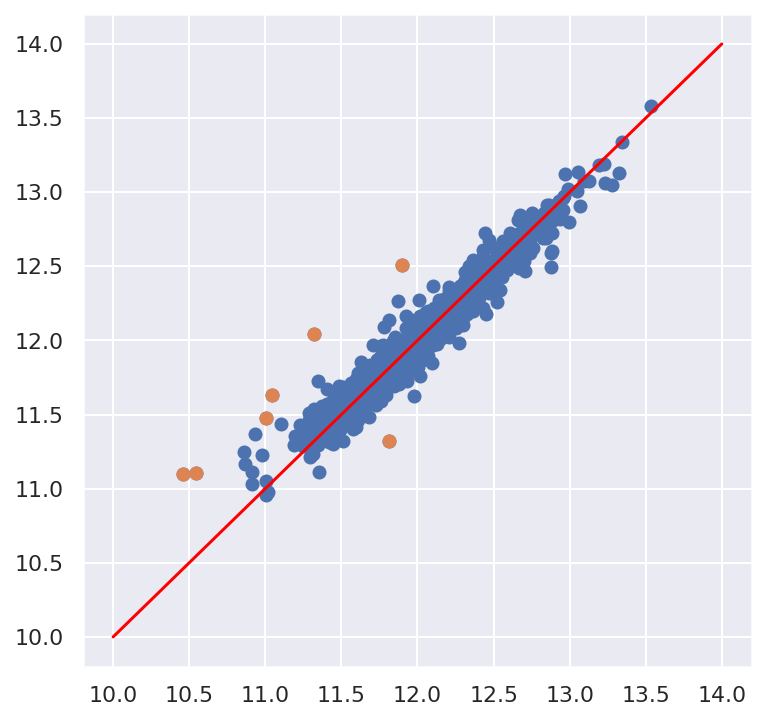

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred)
plt.scatter(y_train.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

In [26]:
outliers2

array([ 65, 103, 244, 350, 527, 530, 652])

In [27]:
Z_train = Z_train.drop(Z_train.index[[outliers2]])

/home/jordan/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [28]:
y_train = y_train.drop(y_train.index[[outliers2]])

## Gradient Boost Model Optimization

In [29]:
# GridSearchCV to find best params for the pipe
model = cb.CatBoostRegressor(silent=True)
params = {
    'iterations': [100,300,500],
    'learning_rate': [0.1,0.3,0.7],
    'depth': [4,6,10],
    'early_stopping_rounds':[10,20],
    'l2_leaf_reg': [1,3,5],
    'min_child_samples':[1,5,10]
}
grid = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=0)
grid.fit(Z_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

/home/jordan/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.9227723913809749
{'depth': 4, 'early_stopping_rounds': 10, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'min_child_samples': 1}


## Submitting

In [30]:
out_df = pd.read_csv('test.csv')

In [31]:
ZZ_test = mapper.transform(out_df)

In [32]:
final_df = pd.DataFrame(zip(list(out_df['Id']),grid.predict(ZZ_test)), columns = ['Id','SalePrice'])

In [33]:
final_df['SalePrice'] = np.exp(final_df['SalePrice'])

In [36]:
final_df.head()

Id      SalePrice
0  1461  124982.476213
1  1462  160837.945228
2  1463  188156.346348
3  1464  194154.987878
4  1465  193859.727031

In [34]:
final_df.to_csv('sub.csv', index=False)